In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import random
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

## Загрузка данных

In [33]:
random.seed(42)

In [34]:
# BGM_df = pd.read_csv('/Users/alinamaksimova/Documents/i3_shades_of_mind/data/aug_df_BGM.csv')
BGM_df = '/Users/alinamaksimova/Documents/i3_shades_of_mind/aug_df_BGM_copy.csv'

In [35]:
BGM_df = pd.read_csv(BGM_df)

In [36]:
BGM_df.head()

,Unnamed: 0,year,line_length,normalized_radius_sum,madness,RGB1,RGB2,RGB3,RGB4,RGB5,RGB6,RGB7,dark_colors,light_colors
0,0,1882,0.078886,0.041514,0.0,53.0,12.000000,37.666667,68.0,21.333333,160.333333,82.666667,24302.000000,2147.0
1,1,1882,0.086462,0.041514,0.0,53.0,12.000000,37.666667,68.0,21.333333,160.333333,82.666667,24302.000000,2147.0
2,2,1882,0.078886,0.041514,0.0,53.0,2.047055,37.666667,68.0,21.333333,160.333333,82.666667,24302.000000,2147.0
3,3,1882,0.078886,0.041514,0.0,53.0,17.088490,37.666667,68.0,21.333333,160.333333,82.666667,24302.000000,2147.0
4,4,1882,0.078886,0.041514,0.0,53.0,12.000000,37.666667,68.0,21.333333,160.333333,82.666667,27000.499504,2147.0


In [37]:
X = BGM_df.drop(columns=["madness", "year"]) #.values 
y = BGM_df['madness'] #.values

In [38]:
X.head()

,Unnamed: 0,line_length,normalized_radius_sum,RGB1,RGB2,RGB3,RGB4,RGB5,RGB6,RGB7,dark_colors,light_colors
0,0,0.078886,0.041514,53.0,12.000000,37.666667,68.0,21.333333,160.333333,82.666667,24302.000000,2147.0
1,1,0.086462,0.041514,53.0,12.000000,37.666667,68.0,21.333333,160.333333,82.666667,24302.000000,2147.0
2,2,0.078886,0.041514,53.0,2.047055,37.666667,68.0,21.333333,160.333333,82.666667,24302.000000,2147.0
3,3,0.078886,0.041514,53.0,17.088490,37.666667,68.0,21.333333,160.333333,82.666667,24302.000000,2147.0
4,4,0.078886,0.041514,53.0,12.000000,37.666667,68.0,21.333333,160.333333,82.666667,27000.499504,2147.0


In [39]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: madness, dtype: float64

In [40]:
X.shape, y.shape

((269, 12), (269,))

In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             269 non-null    int64  
 1   line_length            269 non-null    float64
 2   normalized_radius_sum  269 non-null    float64
 3   RGB1                   269 non-null    float64
 4   RGB2                   269 non-null    float64
 5   RGB3                   269 non-null    float64
 6   RGB4                   269 non-null    float64
 7   RGB5                   269 non-null    float64
 8   RGB6                   269 non-null    float64
 9   RGB7                   269 non-null    float64
 10  dark_colors            269 non-null    float64
 11  light_colors           269 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 25.3 KB


In [42]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 269 entries, 0 to 268
Series name: madness
Non-Null Count  Dtype  
--------------  -----  
269 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


## Обработка данных

#### Проверка на мультиколлинеарность:

In [121]:
# corr_matrix = X.corr()

In [122]:
# plt.figure(figsize=(20, 16))
# sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f')
# plt.show()

In [123]:
# X.corrwith(y)

Удаляем все, что с отрицательной корреляцией.

In [124]:
# X.drop(columns=[
#     '(51, 49, 49)',
#     '(120, 117, 105)',
#     '(187, 163, 128)',
#     '(128, 79, 53)',
#     '(21, 21, 23)',
#     '(54, 73, 93)',
#     'Count1', 'Count2', 'Count3',
#     'Count4', 'Count5', 'Count6',
#     'Count7', 'count', 'circle_count'
# ], inplace=True)

In [125]:
# corr_matrix = X.corr()

In [126]:
# plt.figure(figsize=(20, 16))
# sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f')
# plt.show()

In [127]:
# X_const = add_constant(X)

# vif_data = pd.DataFrame()
# vif_data["feature"] = X_const.columns
# vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
#                     for i in range(X_const.shape[1])]

# print(vif_data)

In [128]:
# def calculate_vif(data):
#     vif_data = pd.DataFrame()
#     vif_data["feature"] = data.columns
#     vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
#     return vif_data

In [129]:
# vif_info = calculate_vif(X)
# # vif_info
# high_vif = vif_info[vif_info['VIF'] > 200]  # порог
# # high_vif
# X = X.drop(columns=high_vif['feature'])

In [130]:
# X.head()

#### Нормализация

In [131]:
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

In [132]:
# pca = PCA(n_components=0.95)
# X_pca = pca.fit_transform(X_scaled)

In [133]:
# print(f"Форма до PCA: {X_scaled.shape}")
# print(f"Форма после PCA: {X_pca.shape}")

In [134]:
# explained = np.cumsum(pca.explained_variance_ratio_)

In [135]:
# plt.plot(explained, marker='o')
# plt.xlabel("Количество компонент")
# plt.ylabel("Накопленная доля объяснённой дисперсии")
# plt.title("PCA — выбор числа компонент")
# plt.grid()
# plt.show()

## Построение линейной регрессии

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

### Scikit-learn

In [44]:
class MyLinearRegression:
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None
        self.scaler = StandardScaler()

    def fit(self, X, y):
        # X_scaled = self.scaler.fit_transform(X)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
        # theta_best = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y # псевдообратная матрица - mse стал 1.2934...
        self.intercept_ = theta_best[0]
        self.coef_ = theta_best[1:]

    def predict(self, X):
        # X_scaled = self.scaler.transform(X)
        return X @ self.coef_ + self.intercept_

    def score(self, X, y):
        y_pred = self.predict(X)
        u = ((y - y_pred) ** 2).sum()
        v = ((y - y.mean()) ** 2).sum()
        return 1 - u/v

In [45]:
model = MyLinearRegression()

In [46]:
# Инициализация списков для потерь
train_losses = []
val_losses = []

# Количество эпох
num_epochs = 100

# Итеративное обучение с вычислением потерь
for epoch in range(num_epochs):
    # Обучение модели
    model.fit(X_train, y_train)
    
    # Предсказания для обучающей и тестовой выборок
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_test)
    
    # Вычисление MSE
    train_loss = mean_squared_error(y_train, y_train_pred)
    val_loss = mean_squared_error(y_test, y_val_pred)
    
    # Сохранение потерь
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Вывод примерных значений (для проверки)
print(f"Последнее значение train_loss: {train_losses[-1]}")
print(f"Последнее значение val_loss: {val_losses[-1]}")

# Дополнительное вычисление и вывод MSE для последней эпохи
final_mse_train = train_losses[-1]
final_mse_val = val_losses[-1]
print(f"Итоговое MSE для обучающей выборки: {final_mse_train}")
print(f"Итоговое MSE для тестовой выборки: {final_mse_val}")

Последнее значение train_loss: 0.033655090725140446
Последнее значение val_loss: 0.03910258442367485
Итоговое MSE для обучающей выборки: 0.033655090725140446
Итоговое MSE для тестовой выборки: 0.03910258442367485


In [ ]:
# model = MyLinearRegression()

# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

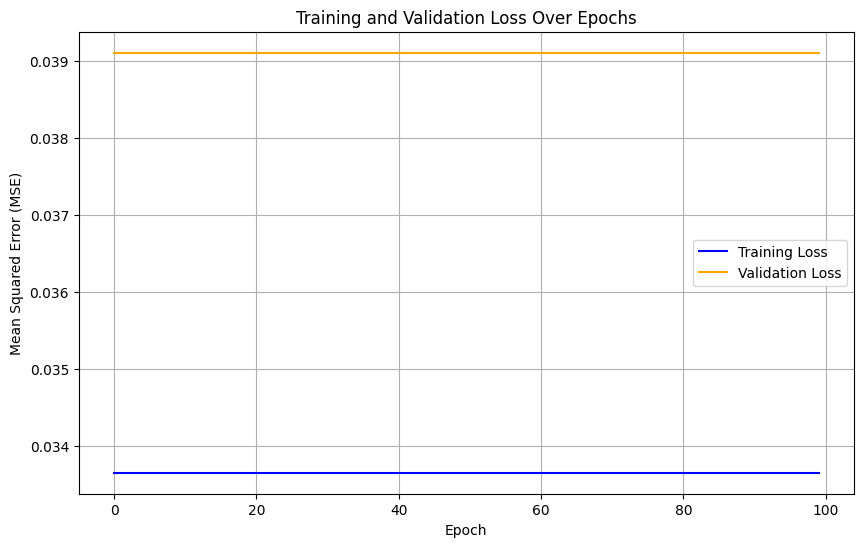

In [47]:
# Ячейка для построения графика потерь
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error

# Предположим, у вас есть предсказания и истинные значения
y_pred = model.predict(X_test)  # Предсказания на тестовых данных
y_true = y_test  # Истинные значения

# Вычисление MSE
mse = mean_squared_error(y_true, y_pred)
print("MSE на тестовой выборке:", mse)

MSE на тестовой выборке: 0.03910258442367485


In [49]:
r2 = model.score(X_test, y_test)
print(f"Коэффициент детерминации (R^2): {r2}")

mse = mean_squared_error(y_test, y_pred)
print("MSE на тестовой выборке:", mse)

mae = np.mean(np.abs(y_test - y_pred))
print("MAE на тестовой выборке:", mae)

Коэффициент детерминации (R^2): 0.36340466864993326
MSE на тестовой выборке: 0.03910258442367485
MAE на тестовой выборке: 0.15558958340357232


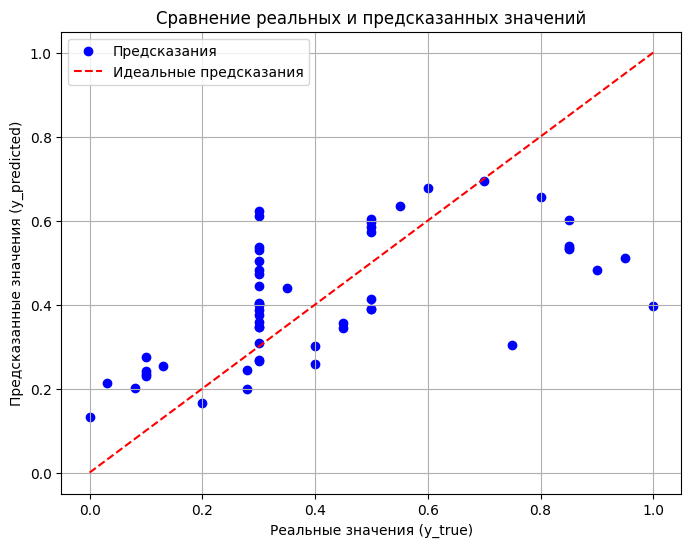

In [50]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Идеальные предсказания")

plt.xlabel("Реальные значения (y_true)")
plt.ylabel("Предсказанные значения (y_predicted)")
plt.title("Сравнение реальных и предсказанных значений")
plt.legend()
plt.grid(True)
plt.show()

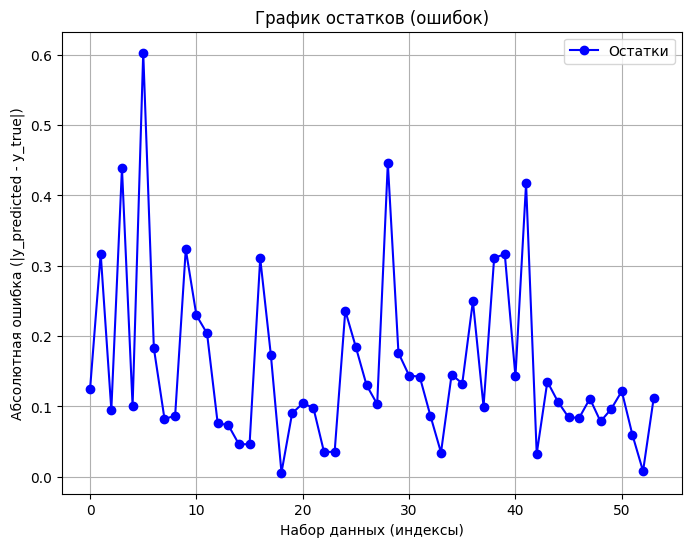

In [51]:
errors = np.abs(np.array(y_pred) - np.array(y_test))

plt.figure(figsize=(8, 6))
plt.plot(errors, marker='o', linestyle='-', color='b', label='Остатки')
plt.xlabel("Набор данных (индексы)")
plt.ylabel("Абсолютная ошибка (|y_predicted - y_true|)")
plt.title("График остатков (ошибок)")
plt.grid(True)
plt.legend()
plt.show()

Регрессия из sklearn:

In [142]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [143]:
print("Оценка модели на обучающих данных:")
print(f"R² (обучение): {r2_score(y_train, y_pred_train):.4f}")
print(f"MAE (обучение): {mean_absolute_error(y_train, y_pred_train):.4f}")
print(f"MSE (обучение): {mean_squared_error(y_train, y_pred_train):.4f}")

print("\nОценка модели на тестовых данных:")
print(f"R² (тест): {r2_score(y_test, y_pred_test):.4f}")
print(f"MAE (тест): {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"MSE (тест): {mean_squared_error(y_test, y_pred_test):.4f}")

Оценка модели на обучающих данных:
R² (обучение): 0.9980
MAE (обучение): 0.0107
MSE (обучение): 0.0002

Оценка модели на тестовых данных:
R² (тест): 0.9986
MAE (тест): 0.0089
MSE (тест): 0.0001


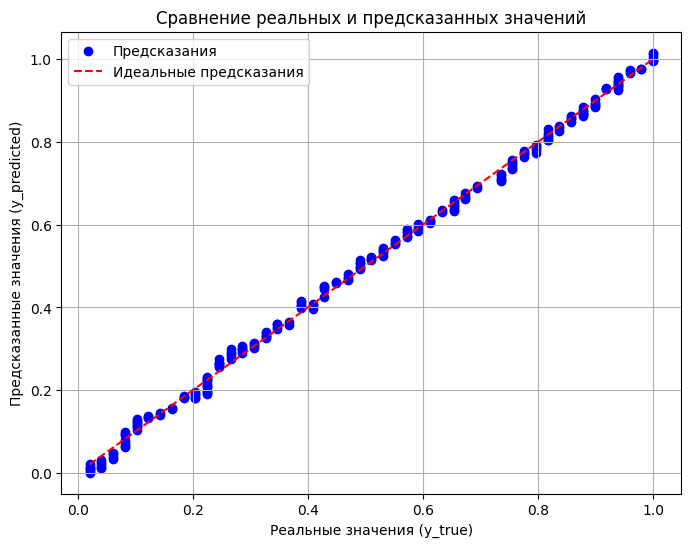

In [144]:
plt.figure(figsize=(8, 6))

plt.scatter(y_train, y_pred_train, color='blue', label='Предсказания')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--', label="Идеальные предсказания")

plt.xlabel("Реальные значения (y_true)")
plt.ylabel("Предсказанные значения (y_predicted)")
plt.title("Сравнение реальных и предсказанных значений")
plt.legend()
plt.grid(True)
plt.show()

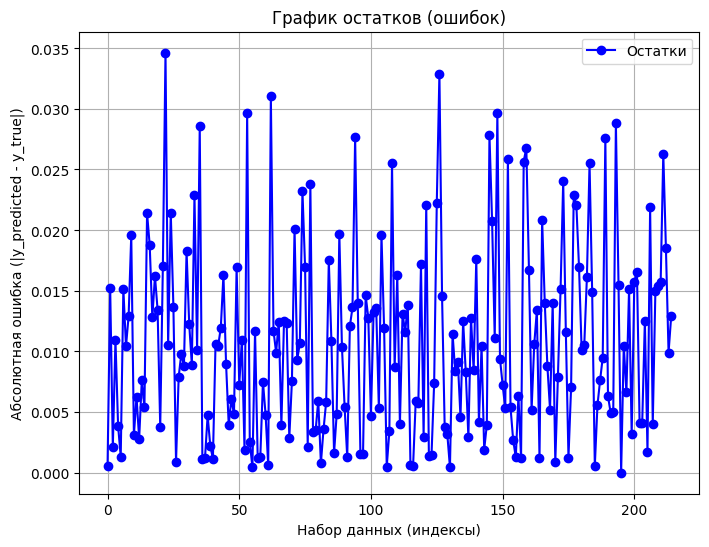

In [145]:
errors = np.abs(np.array(y_pred_train) - np.array(y_train))

plt.figure(figsize=(8, 6))
plt.plot(errors, marker='o', linestyle='-', color='b', label='Остатки')
plt.xlabel("Набор данных (индексы)")
plt.ylabel("Абсолютная ошибка (|y_predicted - y_true|)")
plt.title("График остатков (ошибок)")
plt.grid(True)
plt.legend()
plt.show()

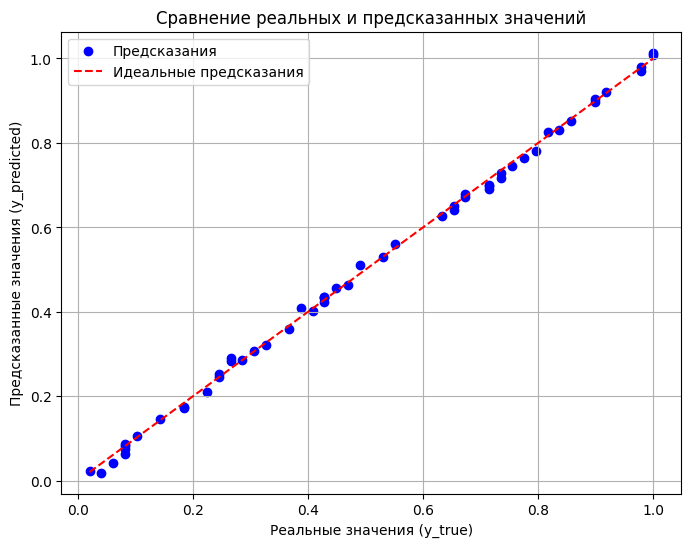

In [146]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred_test, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Идеальные предсказания")

plt.xlabel("Реальные значения (y_true)")
plt.ylabel("Предсказанные значения (y_predicted)")
plt.title("Сравнение реальных и предсказанных значений")
plt.legend()
plt.grid(True)
plt.show()

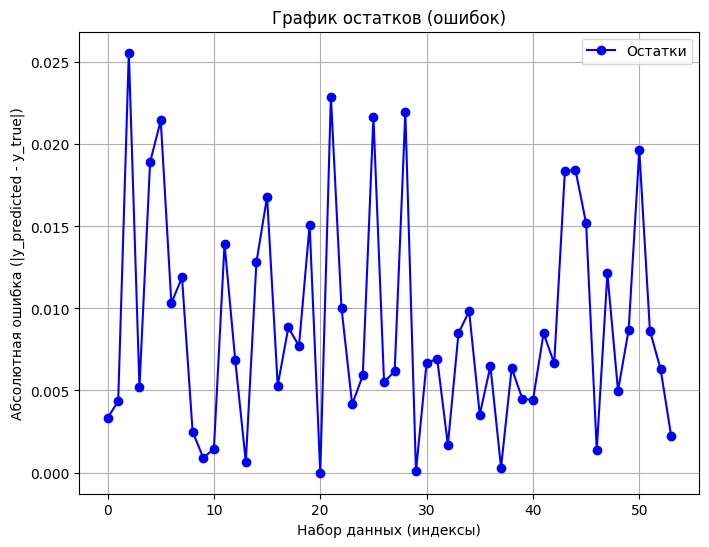

In [147]:
errors = np.abs(np.array(y_pred_test) - np.array(y_test))

plt.figure(figsize=(8, 6))
plt.plot(errors, marker='o', linestyle='-', color='b', label='Остатки')
plt.xlabel("Набор данных (индексы)")
plt.ylabel("Абсолютная ошибка (|y_predicted - y_true|)")
plt.title("График остатков (ошибок)")
plt.grid(True)
plt.legend()
plt.show()

In [162]:
with open('mylinreg_model.pkl', 'wb') as file:
    pickle.dump(model, file)

Регрессия Ridge:

In [148]:
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

In [149]:
ridge_r2 = ridge.score(X_test, y_test)
print(f"Коэффициент детерминации (R^2) для Ridge: {ridge_r2}")

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
print("Ridge MAE:", mae_ridge)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print("Ridge MSE:", mse_ridge)

Коэффициент детерминации (R^2) для Ridge: 0.9985960139636545
Ridge MAE: 0.009015943597726228
Ridge MSE: 0.00012244567931554134


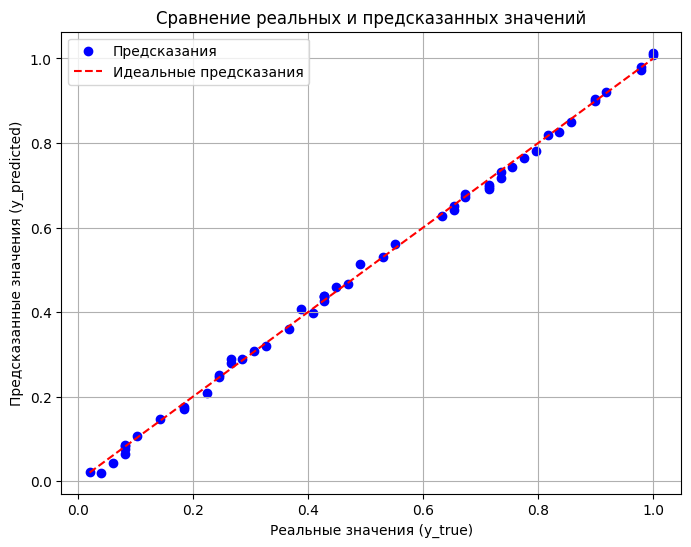

In [150]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred_ridge, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Идеальные предсказания")

plt.xlabel("Реальные значения (y_true)")
plt.ylabel("Предсказанные значения (y_predicted)")
plt.title("Сравнение реальных и предсказанных значений")
plt.legend()
plt.grid(True)
plt.show()

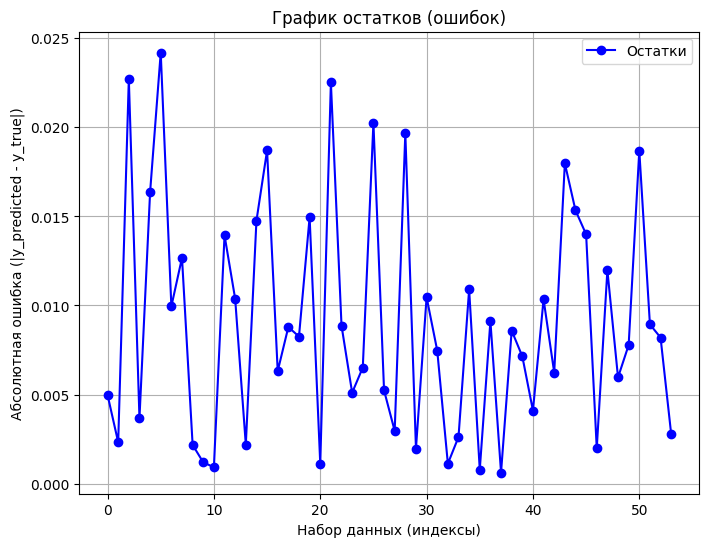

In [151]:
errors = np.abs(np.array(y_pred_ridge) - np.array(y_test))

plt.figure(figsize=(8, 6))
plt.plot(errors, marker='o', linestyle='-', color='b', label='Остатки')
plt.xlabel("Набор данных (индексы)")
plt.ylabel("Абсолютная ошибка (|y_predicted - y_true|)")
plt.title("График остатков (ошибок)")
plt.grid(True)
plt.legend()
plt.show()

In [163]:
with open('ridge_model.pkl', 'wb') as file:
    pickle.dump(ridge, file)

Регрессия Lasso:

In [152]:
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

In [153]:
lasso_r2 = lasso.score(X_test, y_test)
print(f"Коэффициент детерминации (R^2) для Lasso: {lasso_r2}")

mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
print("Ridge MAE:", mae_lasso)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print("Ridge MSE:", mse_lasso)

Коэффициент детерминации (R^2) для Lasso: 0.9983229917371808
Ridge MAE: 0.009978538900743352
Ridge MSE: 0.00014625673663619496


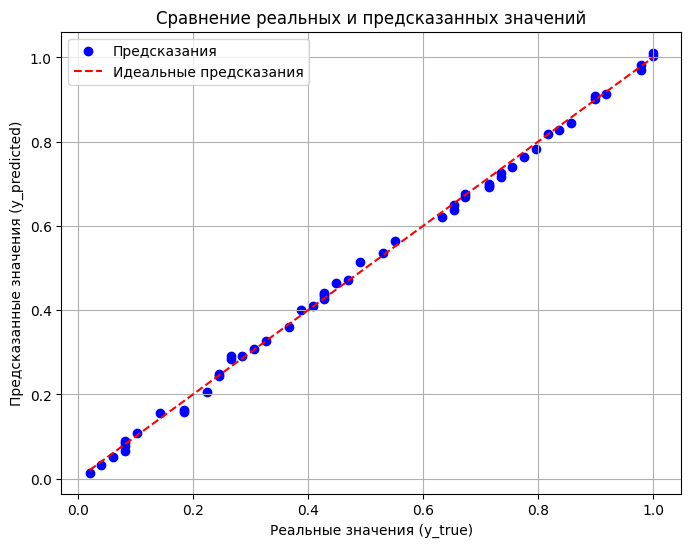

In [154]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred_lasso, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Идеальные предсказания")

plt.xlabel("Реальные значения (y_true)")
plt.ylabel("Предсказанные значения (y_predicted)")
plt.title("Сравнение реальных и предсказанных значений")
plt.legend()
plt.grid(True)
plt.show()

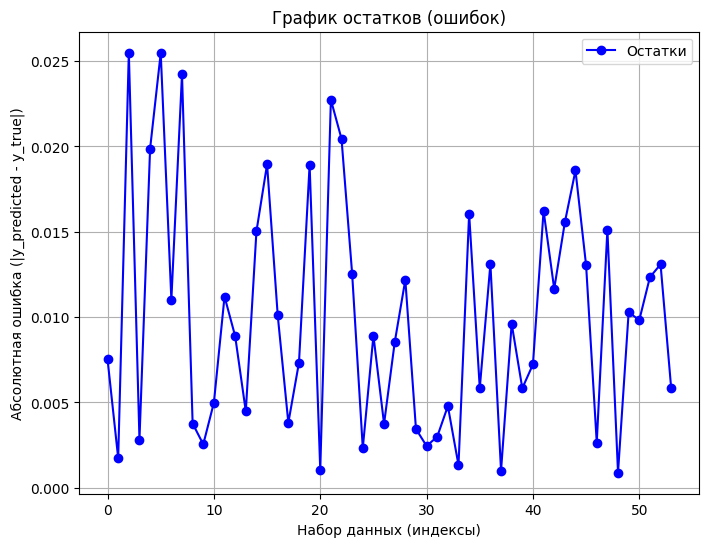

In [155]:
errors = np.abs(np.array(y_pred_lasso) - np.array(y_test))

plt.figure(figsize=(8, 6))
plt.plot(errors, marker='o', linestyle='-', color='b', label='Остатки')
plt.xlabel("Набор данных (индексы)")
plt.ylabel("Абсолютная ошибка (|y_predicted - y_true|)")
plt.title("График остатков (ошибок)")
plt.grid(True)
plt.legend()
plt.show()

Кросс-валидация:

In [156]:
print(X.shape)
print(y.shape)

(269, 12)
(269,)


In [157]:
scores = cross_val_score(lasso, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Средняя ошибка на кросс-валидации: {-scores.mean()}")

Средняя ошибка на кросс-валидации: 0.00029771819141227577


In [164]:
with open('lasso_model.pkl', 'wb') as file:
    pickle.dump(lasso, file)

### Pytorch

In [178]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [179]:
# X_train_sub_tensor = torch.tensor(X_train_sub, dtype=torch.float32)
# X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
# y_train_sub_tensor = torch.tensor(y_train_sub.values, dtype=torch.float32).reshape(-1, 1)
# y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)

X_train_sub_tensor = torch.tensor(X_train_sub.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_train_sub_tensor = torch.tensor(y_train_sub.values, dtype=torch.float32).reshape(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)

In [180]:
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

In [181]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(LinearModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.layer3 = nn.Linear(hidden_dim // 2, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  # Регуляризация
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.layer3(x)
        return x

In [182]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model = LinearModel(X_train.shape[1], hidden_dim=64)
model.apply(init_weights)

LinearModel(
  (layer1): Linear(in_features=12, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [183]:
model = LinearModel(X_train.shape[1])
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2-регуляризация
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50)

In [184]:
class EarlyStopping:
    def __init__(self, patience=100, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [185]:
train_losses = []
val_losses = []
early_stopping = EarlyStopping(patience=100)
num_epochs = 5000
for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_sub_tensor)
    loss = criterion(outputs, y_train_sub_tensor)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    scheduler.step(val_loss)
    early_stopping(val_loss)
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

  4%|▍         | 203/5000 [00:00<00:06, 765.57it/s]

Epoch [100/5000], Train Loss: 47357.1133, Val Loss: 1602.2030
Epoch [200/5000], Train Loss: 12875.1455, Val Loss: 147.7794


  8%|▊         | 388/5000 [00:00<00:06, 732.11it/s]

Epoch [300/5000], Train Loss: 3545.7598, Val Loss: 32.6499
Early stopping triggered


In [186]:
# model.eval()
# with torch.no_grad():
#     y_pred_tensor = model(X_test_tensor)
#     y_pred = y_pred_tensor.numpy()

In [187]:
print("PyTorch R²:", r2_score(y_test, y_pred))
print("PyTorch MAE:", mean_absolute_error(y_test, y_pred))
print("PyTorch MSE:", mean_squared_error(y_test, y_pred))

PyTorch R²: 0.998571337000389
PyTorch MAE: 0.008929880312509016
PyTorch MSE: 0.00012459782859071544


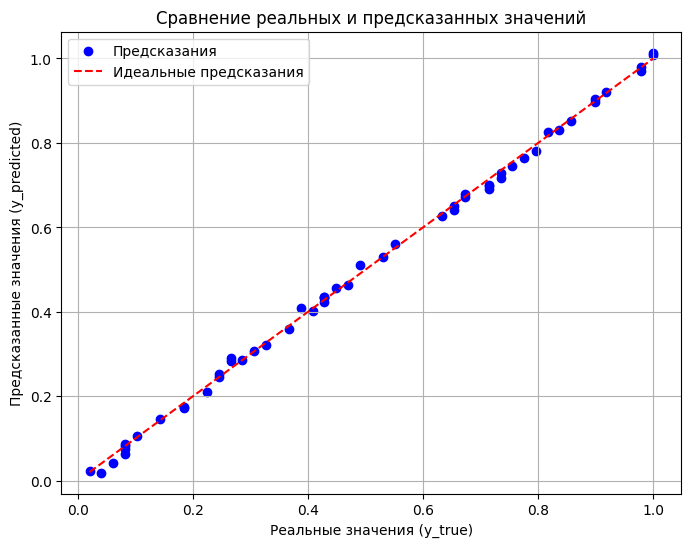

In [188]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Предсказания')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Идеальные предсказания")

plt.xlabel("Реальные значения (y_true)")
plt.ylabel("Предсказанные значения (y_predicted)")
plt.title("Сравнение реальных и предсказанных значений")
plt.legend()
plt.grid(True)
plt.show()

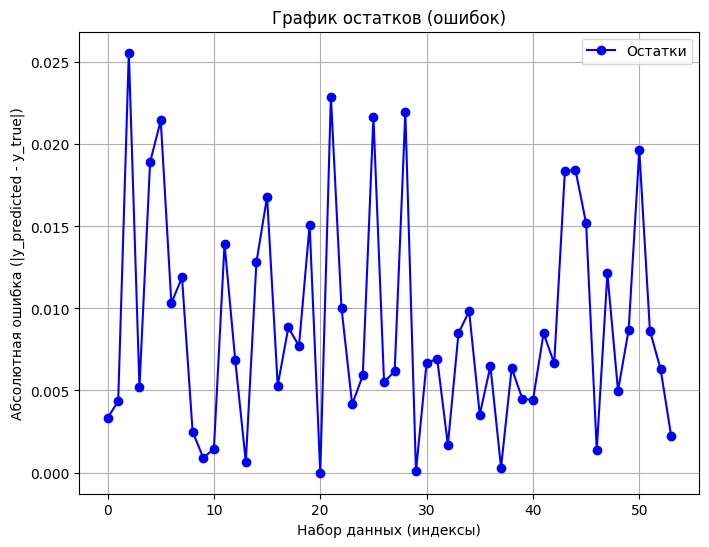

In [189]:
errors = np.abs(np.array(y_pred) - np.array(y_test))

plt.figure(figsize=(8, 6))
plt.plot(errors, marker='o', linestyle='-', color='b', label='Остатки')
plt.xlabel("Набор данных (индексы)")
plt.ylabel("Абсолютная ошибка (|y_predicted - y_true|)")
plt.title("График остатков (ошибок)")
plt.grid(True)
plt.legend()
plt.show()

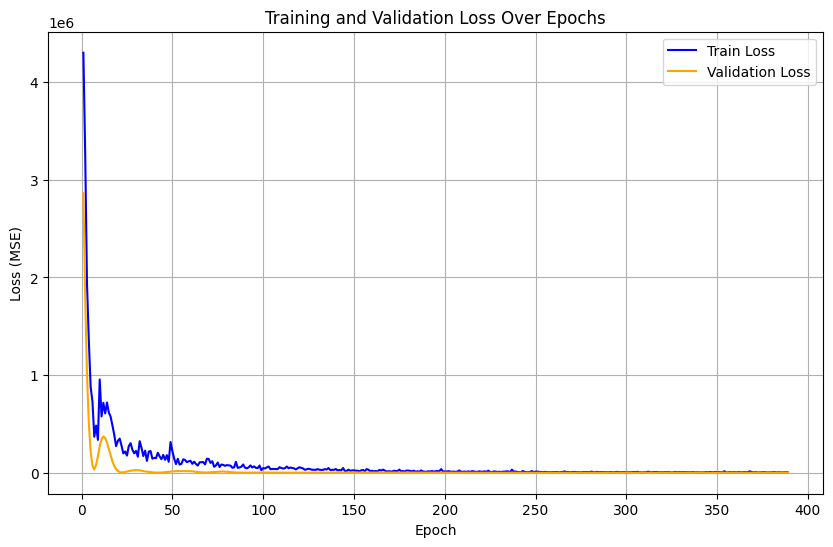

In [190]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [194]:
with open('torch_model.pkl', 'wb') as file:
    pickle.dump(model, file)
